In [1]:
!pip install -q openpyxl
!pip install -q datasets


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from datasets import load_dataset
data = load_dataset('metrec')

/home/magedsaeed/.virtualenvs/openai-evals/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset metrec (/home/magedsaeed/.cache/huggingface/datasets/metrec/plain_text/1.0.0/f7b739eb73ee54df58d0159e35de5d6bdddaf2f661cc17add9f444e7167ef77c)
100%|██████████| 2/2 [00:00<00:00, 362.17it/s]


In [3]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 47124
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 8316
    })
})

In [4]:
meters = [
'السريع',
'الكامل',
'المتقارب',
'المتدارك',
'المنسرح',
'المديد',
'المجتث',
'الرمل',
'البسيط',
'الخفيف',
'الطويل',
'الوافر',
'الهزج',
'الرجز',
]
meter_names_to_labels = {
    meter_name:meter_label for meter_label,meter_name in enumerate(meters)
}
meter_labels_to_names = {meter_label:meter_name for meter_name,meter_label in meter_names_to_labels.items()}

In [5]:
sys_msg = """
Please give the meter of the following Arabic verse, please only specify the meter without any further details. For example, if I give you the following verse:
قفا نبك من ذكرى حبيب ومنزل # بسقط اللوى ثم الدخول فحومل
you answer should be:
الطويل
Now, what is the meter of this verse:
""".strip()
def create_chat_prompt(input_text=sys_msg):
    return [
        {"role": "system", "content": sys_msg}, 
        {"role": "user", "content": input_text}
    ]

def create_chat_example(text, meter_name):
    return [
        {"role": "system", "content": text, "name": "example_user"},
        {"role": "system", "content": meter_name, "name": "example_assistant"},
    ]

In [6]:
!mkdir -p ../registry/data/meter_classification

In [7]:
dev_df = data["train"].to_pandas()
dev_df["sample"] = dev_df.apply(
    lambda x: create_chat_example(
        text=x["text"],
        meter_name=meter_labels_to_names[x["label"]],
    ),
    axis=1,
)
dev_df[["sample"]].to_json(
    "../registry/data/meter_classification/metrec_fewshot.jsonl",
    lines=True,
    orient="records",
)

test_df = data["test"].to_pandas()
test_df["input"] = test_df["text"].apply(lambda x: create_chat_prompt(input_text=x))
test_df["ideal"] = test_df["label"].map(meter_labels_to_names)
test_df[["input", "ideal"]].to_json(
    "../registry/data/meter_classification/metrec_samples.jsonl", lines=True, orient="records"
)


In [8]:
import os
os.environ["OPENAI_API_KEY"] = "<openai-key>"

In [9]:
!ls

ajgt.ipynb  easc.ipynb	metrec.ipynb


In [10]:
!ls ../registry/data/meter_classification

metrec_fewshot.jsonl  metrec_samples.jsonl


In [11]:
meter_classification_task_specs = '''
meter_classification:
    id: meter_classification.test.v1
    metrics: [accuracy]
    description: Evaluate Arabic poetry meter classification
# Define the eval
meter_classification.test.v1:
  # Specify the class name as a dotted path to the module and class
  class: evals.elsuite.classification:Classification
  args:
    samples_jsonl: meter_classification/metrec_samples.jsonl
    few_shot_jsonl: meter_classification/metrec_fewshot.jsonl # path to few shots file
    num_few_shot: 5 # max few shots to use

'''.strip()
with open('../registry/evals/meter_classification.yaml','w') as file:
  file.write(meter_classification_task_specs)

In [12]:
!oaieval gpt-3.5-turbo meter_classification --max_samples 10

[2023-04-04 08:16:58,835] [registry.py:156] Loading registry from /home/magedsaeed/MyProjects/evals/evals/registry/evals
[2023-04-04 08:16:58,976] [registry.py:156] Loading registry from /home/magedsaeed/.evals/evals
[2023-04-04 08:16:59,916] [oaieval.py:213] Run started: 230404051659T6F63267
[2023-04-04 08:16:59,919] [data.py:75] Fetching meter_classification/metrec_fewshot.jsonl
[2023-04-04 08:17:00,302] [data.py:75] Fetching meter_classification/metrec_samples.jsonl
[2023-04-04 08:17:00,435] [eval.py:32] Evaluating 10 samples
[2023-04-04 08:17:00,440] [eval.py:152] Running in threaded mode with 10 threads!
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  3.49it/s]
[2023-04-04 08:17:03,326] [record.py:320] Final report: {'accuracy': 0.1}. Logged to /tmp/evallogs/230404051659T6F63267_gpt-3.5-turbo_meter_classification.jsonl
[2023-04-04 08:17:03,326] [oaieval.py:231] Final report:
[2023-04-04 08:17:03,326] [oaieval.py:233] accuracy: 0.1
[2023-04-04 08:17:03,359] [

In [13]:
!ls /tmp/evallogs

230404050812KM4NUUAG_gpt-3.5-turbo_meter_classification.jsonl
230404051341VKI7KM2X_gpt-3.5-turbo_meter_classification.jsonl
2304040514224SUMAYKV_gpt-3.5-turbo_meter_classification.jsonl
230404051659T6F63267_gpt-3.5-turbo_meter_classification.jsonl


In [14]:
import pandas as pd
events = f"/tmp/evallogs/230404051659T6F63267_gpt-3.5-turbo_meter_classification.jsonl"

with open(events, "r") as f:
    events_df = pd.read_json(f, lines=True)

In [15]:
events_df[events_df['final_report'].notnull()]['final_report']

1    {'accuracy': 0.1}
Name: final_report, dtype: object

<Axes: title={'center': 'Correctness of generated answers'}, xlabel='Correctness', ylabel='Count'>

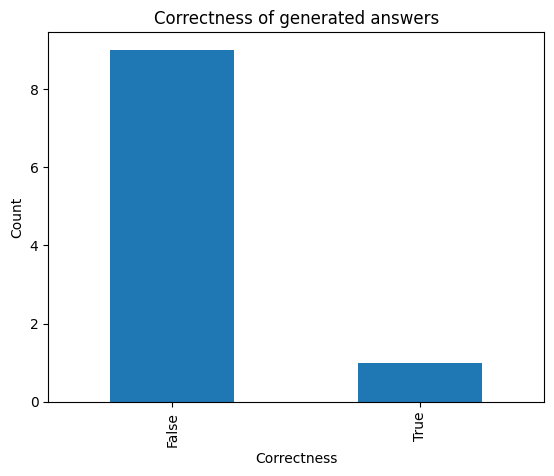

In [17]:
matches_df = events_df[events_df.type == "classification"].reset_index(drop=True)
matches_df = matches_df.join(pd.json_normalize(matches_df.data))
matches_df.accuracy.value_counts().plot.bar(title="Correctness of generated answers", xlabel="Correctness", ylabel="Count")

In [18]:
for i, r in pd.json_normalize(events_df[events_df.type == "sampling"].data).iterrows():
    print(f"Prompt: {r.prompt[-1]}")
    print(f"Sampled: {r.sampled}")
    print(f"{i}","--" * 25)

Prompt: {'role': 'user', 'content': 'خافٍ عَلى كُلِّ أَعمى # مِنهُ يَراهُ البَصيرُ'}
Sampled: الكامل
0 --------------------------------------------------
Prompt: {'role': 'user', 'content': 'وَمَا أَشعَبِي الخِلالِ إِلا كَباسِط # لِيَشرَبَ راحاً بِالإِشارَةِ فِي الوَهدِ'}
Sampled: المديد.
1 --------------------------------------------------
Prompt: {'role': 'user', 'content': 'نَعوذُ بِالإِقرارِ مِن قَرارِها # وَشَرَّ تَقرينِ ذَويها في الزُبُر'}
Sampled: الوافر.
2 --------------------------------------------------
Prompt: {'role': 'user', 'content': 'فَما زادَهُ رَبُّهُ قُوَّةً # وَمِثلُ مُجاوِرِهِ لَم يُقِم'}
Sampled: الوافر.
3 --------------------------------------------------
Prompt: {'role': 'user', 'content': 'وداعي الجود يروي عن رباحٍ # وداعي اليأس يروي عن أُسامهْ'}
Sampled: المجتث
4 --------------------------------------------------
Prompt: {'role': 'user', 'content': 'وَتَغبِطُ كُلّاً عَلى ما حَواهُ # وَما لَكَ في العَيشِ مِن غابِطِ'}
Sampled: الوافر.
5 ------------------------